In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def plot_spatiotemporal_prism(df, id, ax=None):
    df_id = df[df['脱敏ID'] == id].copy()
    
    df_id['start_time'] = pd.to_datetime(df_id['开始时间'])
    df_id['end_time'] = pd.to_datetime(df_id['结束时间'])
    
    df_id['start_time_num'] = df_id['start_time'].astype('int64') // 10**9
    df_id['end_time_num'] = df_id['end_time'].astype('int64') // 10**9
    
    
    if ax is None:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111, projection='3d')
    
    x, y, z = [], [], []
    for _, row in df_id.iterrows():
        xx = row['lnt_wgs84']
        yy = row['lat_wgs84']
        zz = [row['start_time_num'], row['end_time_num']]
        
        x += [xx, xx]
        y += [yy, yy]
        z += zz
        
    ax.plot(x, y, z, marker='o')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Time')

    return df_id, [x,y,z]


def data_completeness(df):
    unique_ids = list(set(d["脱敏ID"]))
    info = {}
    for uid in unique_ids:
        this_df = df.loc[df["脱敏ID"] == uid]
        num_records = this_df.shape[0]
        num_valid_records = 0
        num_seconds = 0
        for idx, row in this_df.iterrows():
            missing = any([(type(row[col]) in [int, float] and np.isnan(row[col])) for col in ["lnt_wgs84", "lat_wgs84", "开始时间", "结束时间"]])
            if not missing:
                num_valid_records += 1
                this_num_seconds = row["场景停留时长"] if row["场景停留时长"] > 0 else 0
                num_seconds += this_num_seconds
        info[uid] = {
            "num_records": num_records,
            "num_valid_records": num_valid_records,
            "num_seconds": num_seconds,
        }
    return info

In [3]:
d = pd.read_csv("traces.csv")
print(d.columns)
print(d.shape)

Index(['脱敏ID', 'lnt_wgs84', 'lat_wgs84', '开始时间', '结束时间', '场景停留时长', '场景名称',
       '品牌名称', '场景楼层', 'poi所属省份', 'poi所属城市', 'poi详细地址', '场景一级分类', '场景二级分类',
       '场景三级分类', '点位来源', 'lnt_bd09', 'lat_bd09', 'lnt_gcj02', 'lat_gcj02'],
      dtype='object')
(7531, 20)


In [4]:
d.head(2)

,脱敏ID,lnt_wgs84,lat_wgs84,开始时间,结束时间,场景停留时长,场景名称,品牌名称,场景楼层,poi所属省份,poi所属城市,poi详细地址,场景一级分类,场景二级分类,场景三级分类,点位来源,lnt_bd09,lat_bd09,lnt_gcj02,lat_gcj02
0,136c54d3-dee7-3d9b-9e55-3b0530225a31,121.266655,31.005476,2022/1/17 18:53,2022/1/17 18:53,0.3015,上海宝利德汽车有限公司,梅赛德斯-奔驰,NaN,上海市,上海市,上海市松江区车墩镇北松公路6656号2幢,购物,车辆,NaN,SceneReco,121.277663,31.009037,121.271070,31.003338
1,4dbfb60a-fd87-3407-a7ab-a5b692d9a8ee,121.422554,31.252909,2022/1/17 04:33,2022/1/17 04:33,0.4769,永辉超市(石泉路会员店),永辉超市,NaN,上海市,上海市,普陀区石泉路123号,购物,超市便利,NaN,SceneReco,121.433632,31.257363,121.427196,31.251075


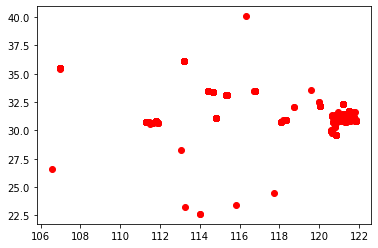

In [5]:
plt.plot(d["lnt_wgs84"], d["lat_wgs84"], "ro")

In [6]:
unique_ids = list(set(d["脱敏ID"]))
print(f"We have {len(unique_ids)} unique IDs")

We have 216 unique IDs


# 时空棱柱图

/var/folders/qc/gzvvv3f13hx20fvx_4jw66bh0000gn/T/ipykernel_16268/3491984208.py:7: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df_id['start_time_num'] = df_id['start_time'].astype('int64') // 10**9
/var/folders/qc/gzvvv3f13hx20fvx_4jw66bh0000gn/T/ipykernel_16268/3491984208.py:8: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df_id['end_time_num'] = df_id['end_time'].astype('int64') // 10**9


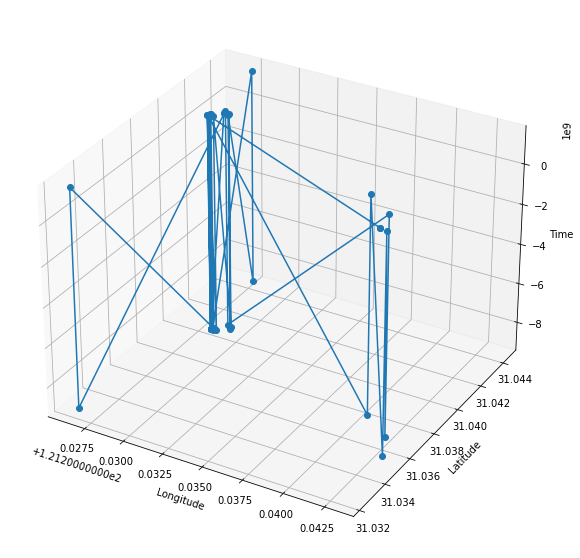

In [7]:
aaa, plot_d = plot_spatiotemporal_prism(d, unique_ids[92])

# 检查数据完整性

In [8]:
info = data_completeness(d)
quality = pd.DataFrame.from_dict(info, orient="index")
quality["valid_ratio"] = quality["num_valid_records"] / quality["num_records"]
quality["valid_hour"] = quality["num_seconds"] / 3600
quality.head()

,num_records,num_valid_records,num_seconds,valid_ratio,valid_hour
5776074d-2094-3867-aaba-cd51d2c45c94,28,11,54.1728,0.392857,0.015048
4c8d7111-aac3-347d-8427-b8ca54284483,19,6,85.5202,0.315789,0.023756
78a58e35-417b-38cb-bb21-b8d9792935c5,88,63,1387.4132,0.715909,0.385393
ac83c919-50b6-3346-8d67-74c69a4ff0c3,8,0,0.0000,0.000000,0.000000
56cd2331-9299-3eb2-8343-c593a876de26,13,0,0.0000,0.000000,0.000000


每个ID的记录数量： 
均值： 34.866
中位数：31.5
最小值：1
最大值：111
标准差：21.037


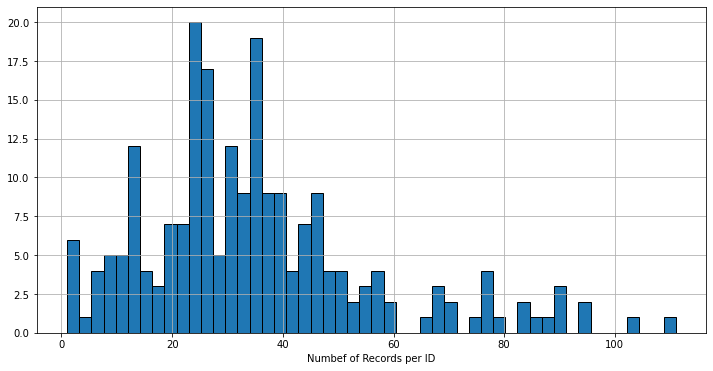

In [9]:
ax = quality["num_records"].hist(bins=50, figsize=(12,6), edgecolor="black")
_ = ax.set_xlabel("Numbef of Records per ID")

print("每个ID的记录数量： \n均值： {:4.3f}\n中位数：{}\n最小值：{}\n最大值：{}\n标准差：{:4.3f}".format(
    quality["num_records"].mean(), quality["num_records"].median(),
    quality["num_records"].min(), quality["num_records"].max(), quality["num_records"].std()
))

每个ID的完整记录数量： 
均值： 8.528
中位数：2.0
最小值：0
最大值：66
标准差：21.037


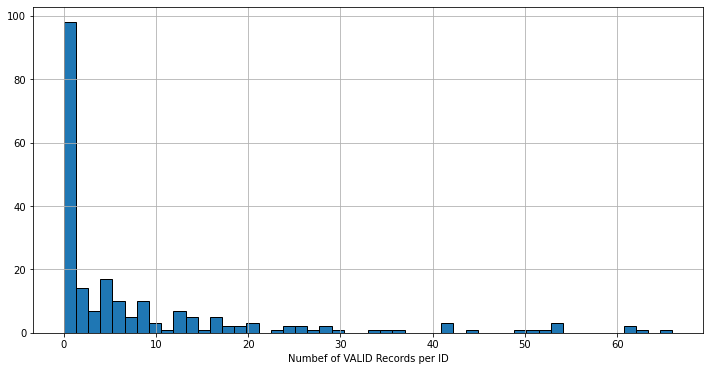

In [10]:
ax = quality["num_valid_records"].hist(bins=50, figsize=(12,6), edgecolor="black")
_ = ax.set_xlabel("Numbef of VALID Records per ID")

print("每个ID的完整记录数量： \n均值： {:4.3f}\n中位数：{}\n最小值：{}\n最大值：{}\n标准差：{:4.3f}".format(
    quality["num_valid_records"].mean(), quality["num_valid_records"].median(),
    quality["num_valid_records"].min(), quality["num_valid_records"].max(), quality["num_records"].std()
))

每个ID的记录完整率 （完整记录数量 / 记录数量）： 
均值： 0.182
中位数：0.083
最小值：0.000
最大值：1.000
标准差：0.224


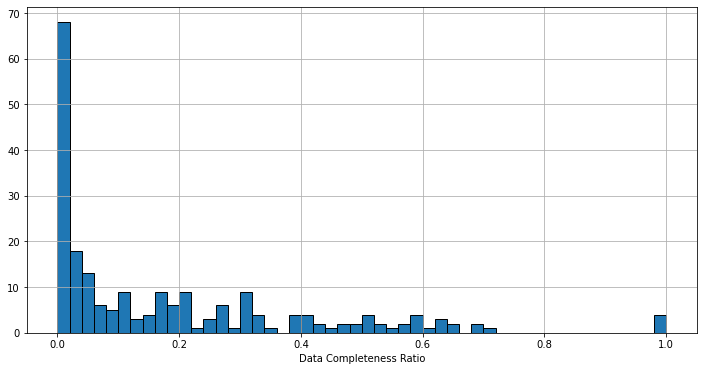

In [11]:
ax = quality["valid_ratio"].hist(bins=50, figsize=(12,6), edgecolor="black")
_ = ax.set_xlabel("Data Completeness Ratio")

print("每个ID的记录完整率 （完整记录数量 / 记录数量）： \n均值： {:4.3f}\n中位数：{:4.3f}\n最小值：{:4.3f}\n最大值：{:4.3f}\n标准差：{:4.3f}".format(
    quality["valid_ratio"].mean(), quality["valid_ratio"].median(),
    quality["valid_ratio"].min(), quality["valid_ratio"].max(), quality["valid_ratio"].std()
))

每个ID的有效记录时长（小时）： 
均值： 0.069
中位数：0.007
最小值：0.000
最大值：1.477
标准差：0.158


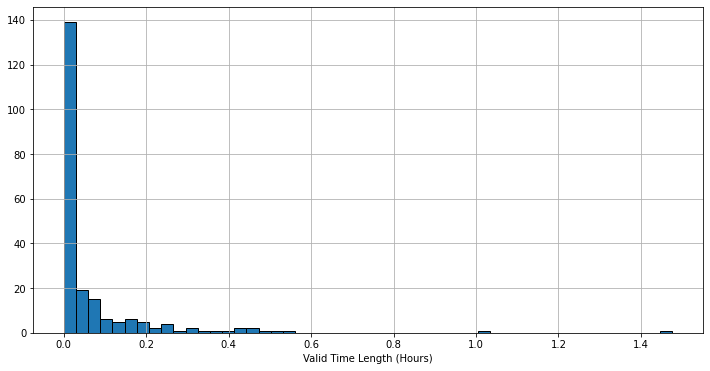

In [12]:
ax = quality["valid_hour"].hist(bins=50, figsize=(12,6), edgecolor="black")
_ = ax.set_xlabel("Valid Time Length (Hours)")

print("每个ID的有效记录时长（小时）： \n均值： {:4.3f}\n中位数：{:4.3f}\n最小值：{:4.3f}\n最大值：{:4.3f}\n标准差：{:4.3f}".format(
    quality["valid_hour"].mean(), quality["valid_hour"].median(),
    quality["valid_hour"].min(), quality["valid_hour"].max(), quality["valid_hour"].std()
))

## 数据不完整的例子

In [13]:
d.loc[d["脱敏ID"]==unique_ids[10]]

,脱敏ID,lnt_wgs84,lat_wgs84,开始时间,结束时间,场景停留时长,场景名称,品牌名称,场景楼层,poi所属省份,poi所属城市,poi详细地址,场景一级分类,场景二级分类,场景三级分类,点位来源,lnt_bd09,lat_bd09,lnt_gcj02,lat_gcj02
2511,363daed0-52e2-3dd4-ba9e-ac665fc01c9d,121.283070,31.030432,2022/1/17 09:09,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Timing,121.294010,31.034274,121.287506,31.028323
2512,363daed0-52e2-3dd4-ba9e-ac665fc01c9d,121.283070,31.030432,2022/1/17 09:10,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Timing,121.294010,31.034274,121.287506,31.028323
2513,363daed0-52e2-3dd4-ba9e-ac665fc01c9d,121.278190,31.024942,2022/1/17 09:42,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Timing,121.289151,31.028687,121.282619,31.022825
2514,363daed0-52e2-3dd4-ba9e-ac665fc01c9d,121.278786,31.026014,2022/1/17 09:47,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Timing,121.289744,31.029770,121.283216,31.023898
2515,363daed0-52e2-3dd4-ba9e-ac665fc01c9d,121.243410,31.024590,2022/1/17 10:12,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Timing,121.254391,31.028165,121.247818,31.022458
2516,363daed0-52e2-3dd4-ba9e-ac665fc01c9d,121.270195,31.110780,2022/1/17 10:34,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Timing,121.281209,31.114447,121.274622,31.108704
2517,363daed0-52e2-3dd4-ba9e-ac665fc01c9d,121.287380,31.143170,2022/1/17 10:47,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Timing,121.298322,31.147164,121.291832,31.141130
2518,363daed0-52e2-3dd4-ba9e-ac665fc01c9d,121.282265,31.147291,2022/1/17 11:04,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Timing,121.293220,31.151183,121.286710,31.145247
2519,363daed0-52e2-3dd4-ba9e-ac665fc01c9d,121.282074,31.147432,2022/1/17 11:24,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Timing,121.293030,31.151320,121.286518,31.145388
2520,363daed0-52e2-3dd4-ba9e-ac665fc01c9d,121.281640,31.144676,2022/1/17 11:34,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Timing,121.292600,31.148555,121.286084,31.142630
